# Serie 10
Ce document contient les différents exercices à réaliser. Veuillez compléter et rendre ces exercices pour la semaine prochaine.

Pour chaque exercice:
* implémentez ce qui est demandé
* commentez votre code
* expliquez **en français or English** ce que vous avez codé dans la cellule correspondante

Dans vos explications à chacun des exercices, indiquez un pourcentage subjectif d'investissement de chaque membre du groupe. **Des interrogations aléatoires en classe pourront être réalisées pour vérifier votre contribution/compréhension**.

Les tentatives infructueuses, les explications, commentaires et analyses des échecs **rapportent des points**. Ne rendez pas copie-blanche, même si votre fonction n'est pas correcte.

## Contributions
*Exercice : [contribution Radomski, contribution Darmanger]*
- 1 : [60%, 40%]

## Exercice 1
Implémentez une type de données abstrait `HashTable` (table de hachage) qui utilise une dispersion linéaire (linear probing strategy) pour résoudre les collisions. La classe `HashTable` et ses fonctions à implémenter sont données - libre à vous cependant d'ajouter de nouvelles méthodes aux classes. Vous pouvez optionnellement utiliser une dispersion quadratique.

Vous devez implémenter une classe `HashableImpl` dont les fonctions sont données. Cela correspond aux éléments qui seront stockés dans la hash table.

In [126]:
import dataclasses
import typing


# Représente un élément pouvant être stocké dans une instance de HashTable.
class HashableImpl[TKey]:
    def __init__(self, key: TKey, is_active: bool = False):
        self.key = key
        self.is_active = is_active  # (useless for you but keep it)

    # Calcule le hash de cette instance de HashableImpl.
    # La valeur retournée est un hash, représenté par un nombre entier.
    def hash(self, table_size: int) -> int:
        key_hash = hash(self.key)
        return key_hash % table_size

    # Retourne la clé comme représentation de cette instance
    # (vous n'avez pas besoin de modifier cette fonction).
    def __str__(self):
        return str(self.key)


@dataclasses.dataclass
class _HashTableCounter:
    collisions: int = dataclasses.field(default=0)


type ProbingStrategy = typing.Literal["linear", "quadratic"]


class HashTable[TKey]:
    def __init__(self, initial_size: int = 17, probing_strategy: ProbingStrategy = "linear"):
        # Check if the initial size is prime
        if not HashTable._is_prime(initial_size):
            raise ValueError("size of hash table must be prime")

        self.probing_strategy = probing_strategy
        self._reinitialize(initial_size)

    def _reinitialize(self, size: int) -> None:
        """Reinitialize the hash table with a new size (size must be a prime number)"""
        assert self._is_prime(size)
        self._table: list[HashableImpl[TKey] | None] = [None for _ in range(size)]
        self._size = 0  # Number of active elements
        self._counter = _HashTableCounter()  # Reset the collision counter

    def number_of_collisions(self):
        """Return the number of collisions that occurred during the last search operation"""
        return self._counter.collisions

    def make_empty(self):
        """Remove all elements from the hash table and reinitialize it (also reset the collision counter)"""
        self._reinitialize(len(self._table))

    def is_empty(self):
        """Return True if the hash table is empty, False otherwise"""
        return self._size == 0

    def insert(self, element: HashableImpl[TKey]) -> None:
        """
        Insert an element into the hash table using linear probing.
        Raises Error if full or if a duplicate is inserted.
        """
        table_size = len(self._table)

        # Check if the table is full
        if self._size == table_size:
            raise Error("attempted to insert an element into full hash table")

        hash = element.hash(table_size)

        for cell_offset in range(table_size):
            # Compute the index of the candidate cell (probing)
            candidate_idx = self._probe(hash, cell_offset, table_size)
            candidate_entry = self._table[candidate_idx]

            # If the current cell can't be used, continue to the next cell
            if candidate_entry is not None and candidate_entry.is_active:
                # If the key is already in the table, raise an error
                if candidate_entry.key == element.key:
                    raise Error("attempted to insert duplicate")

                continue

            # If the cell is empty or inactive (available), insert the element
            element.is_active = True
            self._table[candidate_idx] = element
            self._size += 1
            return

    def remove(
        self, element: HashableImpl[TKey]
    ) -> HashableImpl[TKey]:  # Throws ItemNotFound
        """
        Remove the given element from the hash table.
        Raises ItemNotFound if the element is not found.
        """
        table_size = len(self._table)
        hash = element.hash(table_size)

        for cell_offset in range(table_size):
            candidate_idx = self._probe(hash, cell_offset, table_size)
            candidate_entry = self._table[candidate_idx]

            if candidate_entry is None:
                # If the cell is empty, the element is not in the table
                raise ItemNotFound(element)

            # If the cell is active and the key is the same, remove the element
            if candidate_entry.is_active and candidate_entry.key == element.key:
                # Mark the cell as inactive
                # (tombstone; ensures that further displaced elements are still found)
                candidate_entry.is_active = False
                self._size -= 1
                return candidate_entry

        raise ItemNotFound(element)

    def find(
        self, element: HashableImpl[TKey]
    ) -> HashableImpl[TKey]:  # Throws ItemNotFound
        """Find an element in the hash table"""
        table_size = len(self._table)
        hash = element.hash(table_size)

        for cell_offset in range(table_size):
            candidate_idx = self._probe(hash, cell_offset, table_size)
            candidate_entry = self._table[candidate_idx]

            if candidate_entry is None:
                # We found an empty slot, element not here.
                # Collisions = how many steps we tried before concluding not found.
                self._counter.collisions += cell_offset
                raise ItemNotFound(element)

            if candidate_entry.is_active and candidate_entry.key == element.key:
                # Found the element. Collisions = cell_offset (how far we probed).
                self._counter.collisions += cell_offset
                return candidate_entry

        # If we reach this point, we probed the entire table without finding the element.
        self._counter.collisions += table_size
        raise ItemNotFound(element)

    def _probe(self, hash_idx: int, i: int, table_size: int) -> int:
        """Return the index of the cell to probe based on the probing strategy"""
        if self.probing_strategy == "linear":
            return (hash_idx + i) % table_size
        elif self.probing_strategy == "quadratic":
            return (hash_idx + i * i) % table_size

    @staticmethod
    def _is_prime(n: int) -> bool:
        """Check if a number is prime"""
        if n <= 1:
            return False
        if n == 2:
            return True
        if n % 2 == 0:
            return False
        divisor = 3
        while divisor * divisor <= n:
            if n % divisor == 0:
                return False
            divisor += 2
        return True


class Error(Exception):
    pass


class ItemNotFound(Error):
    pass

In [127]:
def test_unexisting_value(hashable: HashableImpl[int]):
    try:
        _table.find(hashable)
        print("Error: the item '", hashable, "' must not exist in the hash table")
    except ItemNotFound:
        pass
    except Exception as e:
        print("Error: an unexpected exception has been raised", type(e), ":", e)
        raise

_table = HashTable[int]()
assert _table.is_empty() == True
h1 = HashableImpl(156)
_table.insert(h1)
assert _table.is_empty() == False
h2 = HashableImpl(90)
_table.insert(h2)
h3 = HashableImpl(31)
_table.insert(h3)
print("Should display three elements, while the other entries should be None:")
for e in _table._table:
    if e is not None:
        if e.is_active:
            print(e)
    else:
        print(e)
print()

test_unexisting_value(HashableImpl(0))
test_unexisting_value(HashableImpl(1))
assert _table.find(h1) != None
assert _table.find(h2) != None
assert _table.find(h3) != None

temp1 = _table.find(h1)
print("h1: ", temp1.key)
temp3 = _table.find(h3)
print("h3: ", temp3.key)
print()
_table.remove(h2)
print("Should display two elements, while the other entries should be None:")
for e in _table._table:
    if e is not None:
        if e.is_active:
            print(e)
        else:
            print(None)
    else:
        print(e)
print()

test_unexisting_value(HashableImpl(0))
test_unexisting_value(HashableImpl(1))
assert _table.find(h1) != None
test_unexisting_value(h2)
assert _table.find(h3) != None

h4 = HashableImpl(41)
_table.insert(h4)
h5 = HashableImpl(54)
_table.insert(h5)
print("Should display four elements, while the other entries should be None:")
for e in _table._table:
    if e is not None:
        if e.is_active:
            print(e)
        else:
            print(None)
    else:
        print(e)

print()

test_unexisting_value(HashableImpl(0))
test_unexisting_value(HashableImpl(1))
assert _table.find(h1) != None
test_unexisting_value(h2)
assert _table.find(h3) != None
assert _table.find(h4) != None
assert _table.find(h5) != None

h6 = HashableImpl(716)
_table.insert(h6)
print("Should display five elements, while the other entries should be None:")
for e in _table._table:
    if e is not None:
        if e.is_active:
            print(e)
        else:
            print(None)
    else:
        print(e)

print()

test_unexisting_value(HashableImpl(0))
test_unexisting_value(HashableImpl(1))
assert _table.find(h1) != None
test_unexisting_value(h2)
assert _table.find(h3) != None
assert _table.find(h4) != None
assert _table.find(h5) != None
assert _table.find(h6) != None

_table.make_empty()
assert _table.is_empty() == True
print("Should display all entries as None:")
for e in _table._table:
    if e is not None:
        if e.is_active:
            print(e)
        else:
            print(None)
    else:
        print(e)

print()

test_unexisting_value(HashableImpl(0))
test_unexisting_value(HashableImpl(1))
test_unexisting_value(h1)
test_unexisting_value(h2)
test_unexisting_value(h3)
test_unexisting_value(h4)
test_unexisting_value(h5)
test_unexisting_value(h6)

try:
    _table.remove(h4)
    print("Error: an ItemNotFound exception must be raised")
except ItemNotFound:
    pass
except Exception as e:
    print("Error: an unexpected exception has been raised", type(e), ":", e)
    raise

# Test whether tombstones are correctly interpreted
_table = HashTable[int](5)
_element_collision_1 = HashableImpl(1)
_element_collision_2 = HashableImpl(6)

_table.insert(_element_collision_1)
_table.insert(_element_collision_2)
_table.remove(_element_collision_1)

_table.find(_element_collision_2)

Should display three elements, while the other entries should be None:
None
None
None
156
None
90
None
None
None
None
None
None
None
None
31
None
None

h1:  156
h3:  31

Should display two elements, while the other entries should be None:
None
None
None
156
None
None
None
None
None
None
None
None
None
None
31
None
None

Should display four elements, while the other entries should be None:
None
None
None
156
54
None
None
41
None
None
None
None
None
None
31
None
None

Should display five elements, while the other entries should be None:
None
None
716
156
54
None
None
41
None
None
None
None
None
None
31
None
None

Should display all entries as None:
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None



### Explications

This hash table implementation uses open-address hashing with linear probing to deal with collisions.
Open-address hashing means that if an element's hash requires an element to be located at index $i$, but index $i$ is already occupied, we use a probing algorithm to find an alternative bucket.
This is opposed to closed-address hashing schemes where a single bucket can contain multiple entries (typically implemented with linked lists).

The probing strategy needs to ensure the following two things:

- When inserting a new element, it needs to find a slot where the new element can be stored
- When querying an element, it needs to probe all slots in which the element could potentially be stored
  - Not trivial if elements are allowed to be removed (discussed further below)

#### Element indexing

We implemented a linear probing-based approach.

In linear probing, an entry's $x$ th alternative index can be determined using a linear function.
Linear functions are generally of the form $a_0 + a_1 * x$.
While it is possible to use arbitrary constants for $a_0$, we went with the most ordinary constant $1$ (i.e., $idx_{alt} = 1 \bullet i + idx_{orig}$).

Quadratic probing is an alternative to linear probing. 
Instead of using a linear function to determine the next probing index, it uses a quadratic function. 
Quadratic probing can help reduce clustering, but it can also lead to secondary clustering.
 We implemented simply as `idx_alt = (idx_orig + i * i) % table_size`. 

The probing function can easily be changed by modifying the `probing_strategy` parameter in the `HashTable` class.

#### Collision Counter in the find Method:

When a collision occurs (the desired index is already occupied), we linearly probe subsequent cells, we try ` (index + 1) % table_size, (index + 2) % table_size `, and so on — until we find a free slot.

When we call `find(element)`, we start from the element’s ideal position (based on its hash) and linearly probe forward until we find the element or hit an empty cell:

If the element is found at the initial index, the number of collisions is 0.
If we need to check additional slots (e.g., the element is found after probing 3 more indices), the collision count is equal to that offset (3 in this example).
If we encounter an empty cell first, meaning the element is not present, the collision count reflects how many steps we took before concluding that the element is missing.
This collision count thus measures how far from the ideal position we must look, giving an idea of how densely packed the table is around that index.


#### Removal strategies

The indexing scheme alone does not tell us how many elements needs to be queried.
A typical strategy is to continue probing until an empty bucket is encountered.
This strategy needs additional consideration when allowing elements to be removed, as the removal of elements may cause probing to stop prematurely.

The following examples attempts to illustrate this problem:
Consider a hash table of length 5 with elements 1, 6, and 12.
Suppose that an element's hash value is equal to its numeric value.
We first insert elements 1 and 6.
As 6 collides with 1, it is displaced by one bucket.
We then try to insert 12 which collides with 6 (as it is displaced by one bucket), which means that 12 needs to be displaced as well.
Now consider what happens when we remove element 1: Without any precaution, the lookup of 6 would fail as we'd probing after having probed the first bucket.

_We present three strategies that address this problem.
Our implementation uses tombstones._

##### Tombstone (our implementation)

A tombstone is a special marker element that indicates that a particular entry was deleted.
When iterating over possible relocated elements, a tombstone indicates that the iteration should be continued as there might be further relocated entries.

This allows element 6 to retain its position in the presented example, as the first bucket (previously occupied by 1) is not empty but contains a tombstone.

##### Push-back on deletion (alternative strategy)

When we remove an element, we locate the (first) element that was displaced because of the removed element, and move it into the newly emptied bucket.

This process needs to be repeated after every move.
Consider what happens in the example when we remove element 1: The removal of 1 causes 6 to be moved back to its ideal index.
This has an impact on 12, as 12 was displaced because of 6 and would no longer be discoverable if we didn't move it as well.
The removal of a single element can therefore cause several elements to be moved.

Implementations of this scheme need to ensure that an element is not moved past its ideal index.

##### Robin hood hashing (alternative strategy)

Robin hood takes from the rich and gives to the poor.
Robin hood-hashing takes up this idea and applies it to entries stored in the map.
Here, the "wealth" of an entry is defined in terms of its distance to its ideal index.
That is, elements that are displaced by multiple indices are considered poorer than an element that is located at its ideal index.

Robin hood hashing "redistributes" the wealth of elements, meaning that it aims to reduce the variance of the displacement distances.
When probing potential displacement buckets upon insertion, robin hood hashing compares the displacement of the entry at the current displacement index with the displacement of the entry that we'd like to insert.
If the entry at the current displacement index is closer to its ideal index than the element to be inserted is to its respective ideal index, we "swap" the two elements: The insertion entry is put at the current displacement index, and we now try to find a new slot for the element that we replaced.

This approach does not only generally lower the variance of the displacement distances but it also improves the worst case.
Furthermore, it simplifies the implementation of lookups: Iteration can be stopped as soon as an empty bucket _or_ a non-displaced element has been found.
Tombstones are not required in this scheme.

#### Prime table size

Using a prime number for the table size helps achieve a more uniform distribution of hash values and potentially reduces clustering. See *Ex 1.2* for more details.

#### Complexity Considerations:

Generally, hash table operations (insert, find, remove) run in O(1) on average. However, as the load factor increases, the average distance we probe (and thus the collision count) can increase, making these operations less efficient. In the worst case, the complexity of these operations can be O(n).

### Exercice 1.1
Créer une hash table de taille 997. Disperser dans la table $n$ clés, pour chaque $n$ entier dans $[200,900]$.

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import typing


def generate_random_table(table_size: int, element_count: int) -> typing.Tuple[HashTable[int], list[int]]:
    """Generate a random hash table with a given number of elements"""
    table = HashTable[int](table_size)
    keys: list[int] = []

    for _ in range(element_count):
        while True:
            try:
                random_unique_key = get_random_number()
                entry = HashableImpl(random_unique_key)
                table.insert(entry) # Attempt to insert into the table

                keys.append(random_unique_key) # If successful, add key to the list
                break # Break out of the loop if insertion is successful
            except Error:
                # If insertion fails (due to collisions or duplicates), retry with a new key
                pass

    # Ensure the number of keys matches the requested element count
    assert len(keys) == element_count
    return table, keys

def count_misses(table: HashTable[int], query_keys: list[int]) -> int:
    """Count the number of misses when searching for keys in the table"""
    for key in query_keys:
        query_element = HashableImpl(key)
        table.find(query_element)    # Perform the lookup

    return table.number_of_collisions() # Get total number of collisions


def get_random_number() -> int:
    """Return a random number"""
    return np.random.randint(4242)


def run_test(element_count: int) -> int:
    """Run a test with a given number of elements"""
    table, keys = generate_random_table(table_size=997, element_count=element_count)
    # Select 100 distinct keys that are guaranteed to exist in the hash table
    sampled_keys = np.random.choice(keys, 100, replace=False)
    return count_misses(table, list(sampled_keys))

Un *miss* (similaire à une collision) est, lors d'une phase de sondage, la visite d'une cellule de la table qui ne correspond pas à la clé recherchée.

Pour chaque $n$, afficher le nombre de *miss* pour 100 requêtes `find` de clés existantes (les choisir au hasard).



In [129]:
import tqdm

x = np.arange(200, 900, 1)
y: list[int] = []
for idx, element_count in enumerate(tqdm.tqdm(x)):
    misses = run_test(element_count)
    y.append(misses)

    # Display intermediate results every 100 iterations
    if idx % 100 == 0:
        print(f"Processed up to element_count = {element_count}, misses = {misses}")

 17%|█▋        | 117/700 [00:00<00:00, 1168.13it/s]

Processed up to element_count = 200, misses = 9
Processed up to element_count = 300, misses = 14
Processed up to element_count = 400, misses = 16


 53%|█████▎    | 369/700 [00:00<00:00, 1088.53it/s]

Processed up to element_count = 500, misses = 56


 69%|██████▊   | 480/700 [00:00<00:00, 942.05it/s] 

Processed up to element_count = 600, misses = 46
Processed up to element_count = 700, misses = 140


 83%|████████▎ | 578/700 [00:00<00:00, 813.09it/s]

Processed up to element_count = 800, misses = 153


100%|██████████| 700/700 [00:00<00:00, 793.11it/s]


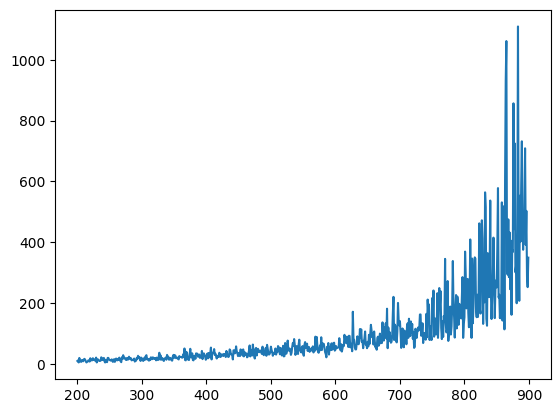

In [130]:
plt.plot(x, y)
plt.show()



Quelle est la relation entre le facteur de charge (load factor) de la table de hachage et le nombre de miss ?

Unsurprisingly, the number of misses is positively correlated to the map's load factor.
As we insert random elements into the list, we can assume the insertion indices to be randomly distributed.
For any element in the list, a higher number of inserted elements therefore increases the chance of a collision.

Let's recall the definition of the load factor: It is the number of elements in the map divided by the number of buckets. The load factor is a measure of how "full" the map is. So if the load factor is high, the map is full, and the chance of a collision is high, which in turn increases the number of misses. For example, with a load factor of 0.5 (half the table filled), the probability of a single probe hitting an occupied cell is approximately 50%. As the load factor approaches 1, this probability approaches 100%, increasing the number of misses exponentially, as we need to probe more cells to find an empty one. As we see in the graph, the number of misses increases with the load factor exponentially.

To solve this issue, we could increase the number of buckets by increasing the size of the hash table. This would decrease the load factor and thus the number of misses. But this would also increase the memory usage of the map. Another solution would be to use a different probing strategy, such as quadratic probing, which could reduce the number of misses. However, this would also increase the complexity of the implementation.

### Exercice 1.2
Quelle est la particularité de 997, la taille choisie pour la hash table ?

997 is a prime number and hence coprime to all numbers smaller than it.
A number is said to be coprime to another if the numbers' greatest common divisor is $1$.

This is relevant when it comes to the dispersion of elements.
Consider the following function which is an approximation of how strings are hashed in java:

```java
public static int hashCode(String str) {
    int result = 0;
    for (int i = 0; i < str.length(); i++) {
        result = 31 * result + Objects.hashCode(str.charAt(i));
    }
    return result;
}
```

Consider what would happen if the hash function didn't use a constant that is coprime with the number of buckets.
Suppose that the hash constant was $2$ and that the list's size was $1000$.
Suppose furthermore that all strings end with the same character (common in some workloads).
This implies that $2$ would be a divisor of all resulting hash codes.
If $2$ also were a divisor of the number of buckets, we'd use our buckets much less efficiently: specifically, we'd use only half of our buckets.

Prime numbers are only coprime to their multiples.
For small constant numbers (or large lists), choosing prime list lengths therefore safeguard against such constants.
Recall that the hash function to be used is user-provided.
Users expect the map to use all of its buckets, regardless of the hash function that they provide.

In practice, it seems to be common to use list lengths that are multiples of two (cf. [OpenJDK](https://github.com/openjdk/jdk/blob/4a22c1fefc879ee50ef032e741e92357284a09bf/src/java.base/share/classes/java/util/HashMap.java#L238), [V8](https://github.com/v8/v8/blob/e3cdab9c8aca23f1c47dc4c0a37a4f05ad79b937/src/base/hashmap.h#L418)).
This means that $2$ must not be used as a constant in hash functions, which is an assumption that generally holds in practice.
Take the example of Java:

- strings are hashed according to the outlined scheme
- integer values hash to their numeric value
- object instances are hashed using the instance's address, unless `Object#hashCode()` is overridden